In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.markers import MarkerStyle

In [ ]:
df = pd.read_csv('/content/hvac_data.csv')

In [ ]:
def preprocess_data(df):
    """
    Preprocess timestamp data in a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing timestamp data.

    Returns:
        df (DataFrame): DataFrame with processed timestamp data.
    """
    # Handle missing values
    df.dropna(inplace=True)

    # Convert timestamp data to datetime format
    df['timestamps'] = pd.to_datetime(df['timestamps'])

    # Extract year, month, day, hour, minute, second
    df['year'] = df['timestamps'].dt.year
    df['month'] = df['timestamps'].dt.month
    df['day'] = df['timestamps'].dt.day
    df['hour'] = df['timestamps'].dt.hour

    return df

df = preprocess_data(df)

In [ ]:
df.head()

,timestamps,location,equipment,temperature,used_power,humidity,year,month,day,hour
0,2022-01-01 00:00:00+09:00,france,air_conditioning,16.85,585.4,94.89,2022,1,1,0
1,2022-01-01 01:00:00+09:00,france,air_conditioning,15.80,8003.6,94.76,2022,1,1,1
2,2022-01-01 02:00:00+09:00,france,air_conditioning,15.42,1033.6,94.96,2022,1,1,2
3,2022-01-01 03:00:00+09:00,france,air_conditioning,17.01,1085.7,94.81,2022,1,1,3
4,2022-01-01 04:00:00+09:00,france,air_conditioning,16.17,3551.7,94.13,2022,1,1,4


In [ ]:
from statsmodels.tsa.seasonal import STL

def decompose_time_series(df, location, equipment, year, month):
    """
    Decompose time series into seasonal, trend, and residual components using STL decomposition.

    Parameters:
        df (DataFrame): DataFrame containing power consumption data.
        location (str): Location identifier.
        equipment (str): Equipment identifier.
        year (int): Year.
        month (int): Month.

    Returns:
        seasonal (Series): Seasonal component of the time series.
        trend (Series): Trend component of the time series.
        residual (Series): Residual component of the time series.
    """

# Don't filter this data, like this, use directly

    # Filter the DataFrame for the selected location, equipment, year, and month
    df_filtered = df[(df['location'] == location) & (df['equipment'] == equipment) &
                     (df['year'] == year) & (df['month'] == month)]

    # Aggregate the data over days
    daily_data = df_filtered.groupby('day')['used_power'].mean()

    # Check if there are at least 7 days (one week) of data for decomposition
    if len(daily_data) < 7:
        raise ValueError("Insufficient data. At least 7 days are required for decomposition.")

    # Perform STL decomposition
    stl = STL(daily_data, seasonal=13, period=7)
    result = stl.fit()

    # Extract components
    seasonal = result.seasonal
    trend = result.trend
    residual = result.resid

    return seasonal, trend, residual

# Example usage:
seasonal, trend, residual = decompose_time_series(df, 'france', 'air_conditioning', 2022, 4)


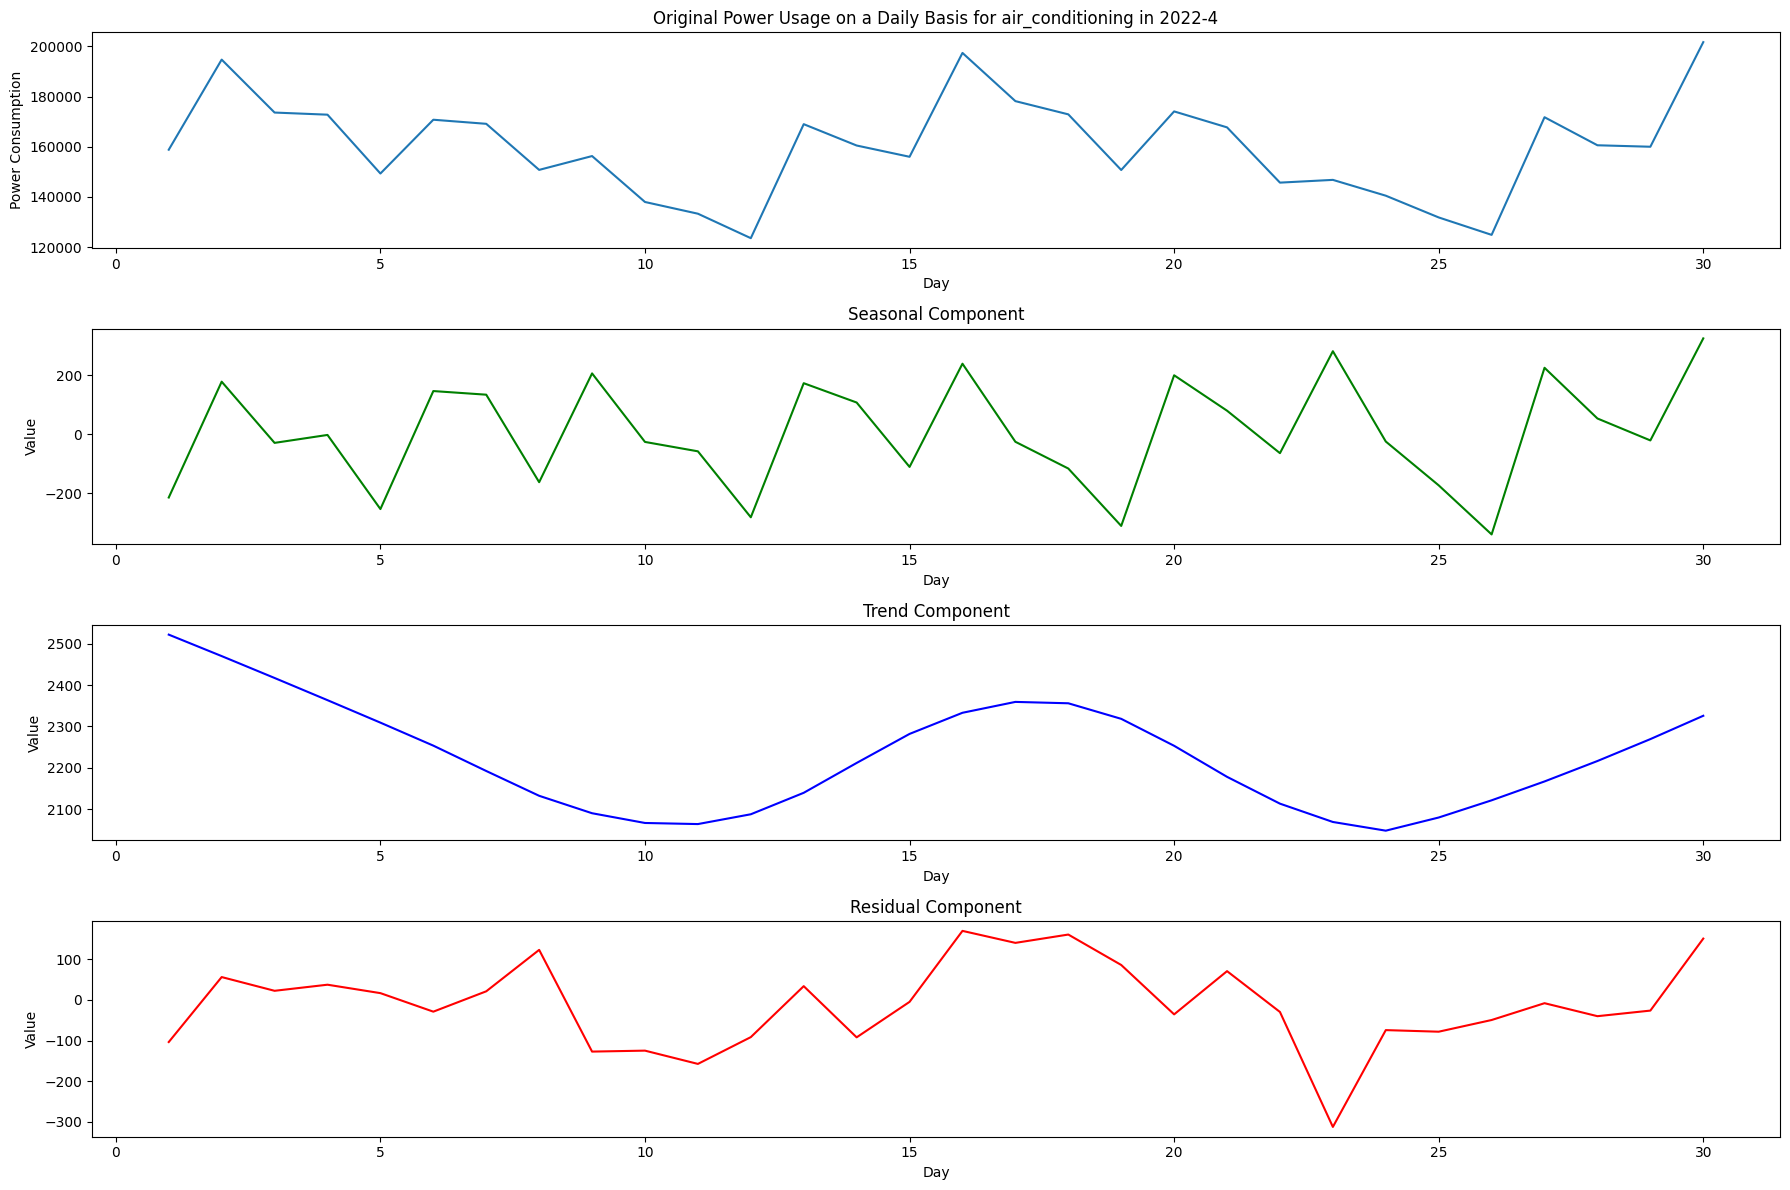

In [ ]:
#Better Function names
#Give only the daily_data_power series as an input

def plot_components(df, year, equipment, month, trend, seasonal, residual):
    """
    Plot power usage components (Original, Residual, Trend, and Seasonal) on a daily basis.

    Parameters:
        df (DataFrame): DataFrame containing power consumption data.
        year (int): Year for which to plot the data.
        equipment (str): Equipment identifier.
        month (int): Month for which to plot the data.
        trend (Series): Trend component of the time series.
        seasonal (Series): Seasonal component of the time series.
        residual (Series): Residual component of the time series.

    Returns:
        None
    """

    #Don't filter like here

    # Filter the DataFrame for the specified year, equipment, and month
    df_filtered = df[(df['year'] == year) & (df['equipment'] == equipment) & (df['month'] == month)]

    # Group the data by day and calculate the total power usage for each day
    daily_power = df_filtered.groupby('day')['used_power'].sum()

    # Create an array of days for the x-axis
    days = np.arange(1, len(daily_power) + 1)

    # Plot the power usage components on a daily basis
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 12))

    # Plot the original power usage
    axes[0].plot(days, daily_power, linestyle='-')
    axes[0].set_title(f'Original Power Usage on a Daily Basis for {equipment} in {year}-{month}')
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel('Power Consumption')

    # Plot the seasonal component
    axes[1].plot(days, seasonal, color='green')
    axes[1].set_title('Seasonal Component')
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Value')

    # Plot the trend component
    axes[2].plot(days, trend, color='blue')
    axes[2].set_title('Trend Component')
    axes[2].set_xlabel('Day')
    axes[2].set_ylabel('Value')

    # Plot the residual component
    axes[3].plot(days, residual, color='red')
    axes[3].set_title('Residual Component')
    axes[3].set_xlabel('Day')
    axes[3].set_ylabel('Value')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
plot_components(df, 2022, 'air_conditioning', 4, trend, seasonal, residual)

In [ ]:
#Naming could be better

def combine_components(trend, seasonal, residual):
    """
    Combine the trend, seasonal, and residual components to reconstruct the original time series data.

    Parameters:
        trend (Series): Trend component of the time series.
        seasonal (Series): Seasonal component of the time series.
        residual (Series): Residual component of the time series.

    Returns:
        reconstructed_time_series (Series): Reconstructed time series data.
    """
    # Create a DataFrame with daily index
    index = pd.date_range('2022-04-01', periods=len(trend), freq='D')

    # Combine components into a DataFrame
    components_df = pd.DataFrame({'Trend': trend.values, 'Seasonal': seasonal.values, 'Residual': residual.values}, index=index)

    # Reconstruct the original time series data
    reconstructed_time_series = components_df['Trend'] + components_df['Seasonal'] + components_df['Residual']

    return reconstructed_time_series

# Example usage:
updated_series = combine_components(trend, seasonal, residual)

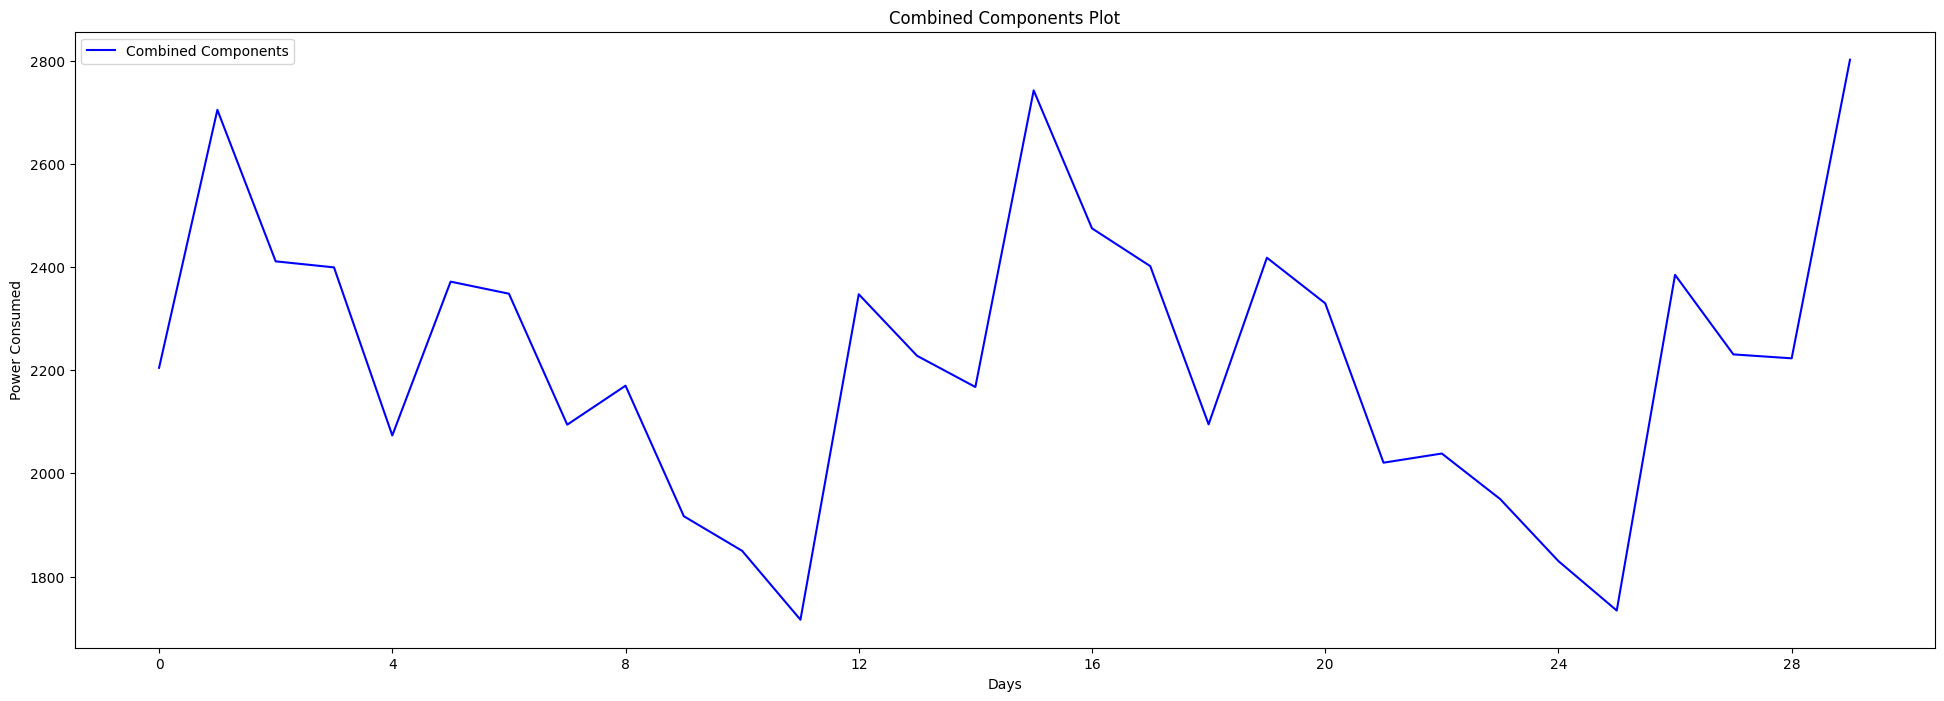

In [ ]:
def plot_combined_components(trend, seasonal, residual):
    """
    Plot the combined components along with the original time series data.

    Parameters:
        trend (Series): Trend component of the time series.
        seasonal (Series): Seasonal component of the time series.
        residual (Series): Residual component of the time series.

    Returns:
        None
    """
    # Create a time index from 0 to n days
    days = np.arange(len(trend))

    # Plot the combined components
    plt.figure(figsize=(24, 8))
    plt.plot(days, trend + seasonal + residual, label='Combined Components', color='blue')

    # Set x-axis ticks every 4 days from 0 to n
    plt.xticks(np.arange(0, len(trend) + 1, 4))

    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('Power Consumed')
    plt.title('Combined Components Plot')
    plt.legend()

    # Show plot
    plt.show()

# Example usage:
plot_combined_components(trend, seasonal, residual)


In [ ]:
updated_series

2022-04-01    2204.537500
2022-04-02    2704.516667
2022-04-03    2410.879167
2022-04-04    2399.191667
2022-04-05    2073.450000
2022-04-06    2371.545833
2022-04-07    2348.175000
2022-04-08    2094.312500
2022-04-09    2169.879167
2022-04-10    1916.870833
2022-04-11    1849.800000
2022-04-12    1716.279167
2022-04-13    2347.091667
2022-04-14    2227.800000
2022-04-15    2167.345833
2022-04-16    2742.212500
2022-04-17    2474.808333
2022-04-18    2401.541667
2022-04-19    2094.929167
2022-04-20    2417.912500
2022-04-21    2329.545833
2022-04-22    2020.645833
2022-04-23    2038.400000
2022-04-24    1950.200000
2022-04-25    1829.816667
2022-04-26    1734.108333
2022-04-27    2384.704167
2022-04-28    2230.520833
2022-04-29    2222.912500
2022-04-30    2801.666667
Freq: D, dtype: float64

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Keep all header files in header
# Import all the functions from the script files

def plot_acf_pacf(series, lags=None):
  """
  Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) of a series.

  Parameters:
      series (pandas.Series): The time series data.
      lags (int, optional): The number of lags to plot. Defaults to None (uses statsmodels default).

  Returns:
      None
  """
  # Create subplots for ACF and PACF
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

  # Plot ACF
  plot_acf(series, ax=ax1, lags=lags, title='ACF of Series')

  # Plot PACF
  plot_pacf(series, ax=ax2, lags=lags, title='PACF of Series')

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_split_data(data, test_size=0.2):
    """
    Split the time series data into training and testing sets.

    Parameters:
        data (DataFrame): DataFrame containing the time series data.
        test_size (float): Proportion of the data to include in the test split.

    Returns:
        train_data (Series): Univariate time series data for training.
        test_data (Series): Univariate time series data for testing.
    """
    # Assuming 'used_power' is the column containing the time series data
    train_data, test_data = train_test_split(data['used_power'], test_size=test_size, shuffle=False)
    return train_data, test_data

In [ ]:
# Assuming train_test_split_data returns a tuple (train_data, test_data)
train_data, test_data = train_test_split_data(df)

In [ ]:
train_data_series = train_data.squeeze()
test_data_series = test_data.squeeze()

In [ ]:
train_data_series

0          585.4
1         8003.6
2         1033.6
3         1085.7
4         3551.7
           ...  
168187    2773.4
168188     342.2
168189    3018.5
168190    1110.5
168191    1068.3
Name: used_power, Length: 168192, dtype: float64

In [ ]:
test_data_series

168192       13.5
168193     1191.3
168194       17.5
168195    10700.0
168196      687.7
           ...   
210235     8827.8
210236      605.8
210237        9.6
210238     1312.9
210239     1891.5
Name: used_power, Length: 42048, dtype: float64

In [ ]:
df.head()

,timestamps,location,equipment,temperature,used_power,humidity,year,month,day,hour
0,2022-01-01 00:00:00+09:00,france,air_conditioning,16.85,585.4,94.89,2022,1,1,0
1,2022-01-01 01:00:00+09:00,france,air_conditioning,15.80,8003.6,94.76,2022,1,1,1
2,2022-01-01 02:00:00+09:00,france,air_conditioning,15.42,1033.6,94.96,2022,1,1,2
3,2022-01-01 03:00:00+09:00,france,air_conditioning,17.01,1085.7,94.81,2022,1,1,3
4,2022-01-01 04:00:00+09:00,france,air_conditioning,16.17,3551.7,94.13,2022,1,1,4


In [ ]:
df.head()

,timestamps,location,equipment,temperature,used_power,humidity,year,month,day,hour
0,2022-01-01 00:00:00+09:00,france,air_conditioning,16.85,585.4,94.89,2022,1,1,0
1,2022-01-01 01:00:00+09:00,france,air_conditioning,15.80,8003.6,94.76,2022,1,1,1
2,2022-01-01 02:00:00+09:00,france,air_conditioning,15.42,1033.6,94.96,2022,1,1,2
3,2022-01-01 03:00:00+09:00,france,air_conditioning,17.01,1085.7,94.81,2022,1,1,3
4,2022-01-01 04:00:00+09:00,france,air_conditioning,16.17,3551.7,94.13,2022,1,1,4


In [ ]:
# Handle missing values
df.dropna(inplace=True)

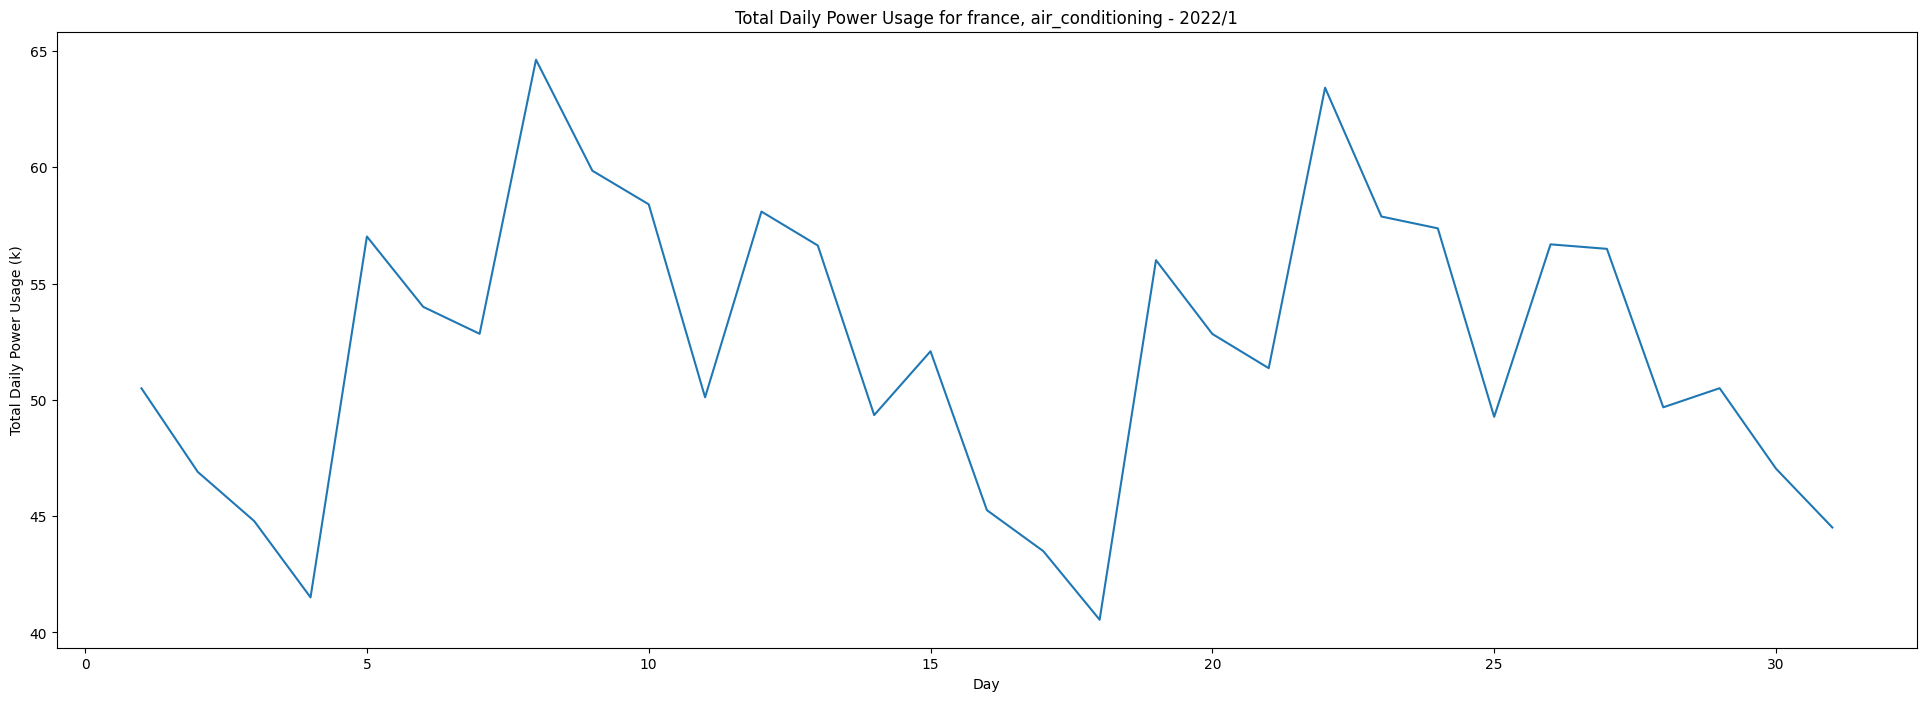

In [ ]:
def plot_daily_power_usage(df, location, equipment, year, month):
    """
    Plot the total daily power usage for a particular day, month, year, location, and equipment.

    Parameters:
        df (DataFrame): DataFrame containing power consumption data.
        location (str): Location identifier.
        equipment (str): Equipment identifier.
        year (int): Year.
        month (int): Month.

    Returns:
        None
    """
    # Filter the DataFrame for the selected location, equipment, year, and month
    df_filtered = df[(df['location'] == location) & (df['equipment'] == equipment) &
                     (df['year'] == year) & (df['month'] == month)]

    # Aggregate the data over days and calculate total daily power usage
    daily_power_usage = df_filtered.groupby('day')['used_power'].sum() / 1000  # Convert to k(1k=1000)

    # Plot the total daily power usage
    plt.figure(figsize=(24, 8))
    plt.plot(daily_power_usage.index, daily_power_usage.values)
    plt.xlabel('Day')
    plt.ylabel('Total Daily Power Usage (k)')
    plt.title(f'Total Daily Power Usage for {location}, {equipment} - {year}/{month}')
    plt.show()

# Example usage
plot_daily_power_usage(df, location='france', equipment='air_conditioning', year=2022, month=1)


In [ ]:
def extract_daily_power_data(df, location, equipment, year, month):
    """
    Extract the used power versus days' data for a particular day, month, year, location, and equipment.

    Parameters:
        df (DataFrame): DataFrame containing power consumption data.
        location (str): Location identifier.
        equipment (str): Equipment identifier.
        year (int): Year.
        month (int): Month.

    Returns:
        daily_power_df (DataFrame): DataFrame containing used power versus days' data.
    """
    # Filter the DataFrame for the selected location, equipment, year, and month
    df_filtered = df[(df['location'] == location) & (df['equipment'] == equipment) &
                     (df['year'] == year) & (df['month'] == month)]

    # Combine year, month, and day columns into a single datetime column
    df_filtered['date'] = pd.to_datetime(df_filtered[['year', 'month', 'day']])

    # Aggregate the data over days and calculate total daily power usage
    daily_power_usage = df_filtered.groupby('date')['used_power'].sum() / 1000  # Convert to k(1k=1000)

    # Create a DataFrame to store the daily power data
    daily_power_df = pd.DataFrame({'Day': daily_power_usage.index.strftime('%Y-%m-%d'),
                                   'Total Power Usage (k)': daily_power_usage.values})

    return daily_power_df

# Example usage
daily_power_data = extract_daily_power_data(df, location='france', equipment='air_conditioning', year=2022, month=1)
print(daily_power_data)


           Day  Total Power Usage (k)
0   2022-01-01                50.4959
1   2022-01-02                46.8997
2   2022-01-03                44.7900
3   2022-01-04                41.5086
4   2022-01-05                57.0203
5   2022-01-06                53.9954
6   2022-01-07                52.8378
7   2022-01-08                64.6196
8   2022-01-09                59.8486
9   2022-01-10                58.4038
10  2022-01-11                50.1092
11  2022-01-12                58.0925
12  2022-01-13                56.6335
13  2022-01-14                49.3443
14  2022-01-15                52.0883
15  2022-01-16                45.2578
16  2022-01-17                43.4971
17  2022-01-18                40.5479
18  2022-01-19                56.0029
19  2022-01-20                52.8314
20  2022-01-21                51.3606
21  2022-01-22                63.4179
22  2022-01-23                57.8790
23  2022-01-24                57.3713
24  2022-01-25                49.2704
25  2022-01-

<ipython-input-20-9edd64cd8806>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered[['year', 'month', 'day']])


In [ ]:
def extract_hourly_power_data(df, location, equipment, year, month):
    """
    Extract the used power versus hours' data for the last 7 days of a particular location, equipment, year, and month.

    Parameters:
        df (DataFrame): DataFrame containing power consumption data.
        location (str): Location identifier.
        equipment (str): Equipment identifier.
        year (int): Year.
        month (int): Month.

    Returns:
        hourly_power_df (DataFrame): DataFrame containing used power versus hours' data for the last 7 days.
    """
    # Filter the DataFrame for the selected location, equipment, year, and month
    df_filtered = df[(df['location'] == location) & (df['equipment'] == equipment) &
                     (df['year'] == year) & (df['month'] == month)]

    # Combine year, month, day, and hour columns into a single datetime column
    df_filtered['datetime'] = pd.to_datetime(df_filtered[['year', 'month', 'day', 'hour']])

    # Filter the data for the last 7 days
    last_7_days = df_filtered['datetime'].max() - pd.DateOffset(days=6)
    df_filtered_last_7_days = df_filtered[df_filtered['datetime'] >= last_7_days]

    # Group the data by date and hour and calculate total power usage for each hour
    hourly_power_usage = df_filtered_last_7_days.groupby([df_filtered_last_7_days['datetime'].dt.date,
                                                          df_filtered_last_7_days['datetime'].dt.hour])[
        'used_power'].sum() / 1000  # Convert to k(1k=1000)

    # Create a DataFrame to store the hour-wise power data
    hourly_power_df = pd.DataFrame({'DateTime': hourly_power_usage.index.map(lambda x: f'{x[0]} {x[1]}:00'),
                                    'Total Power Usage (k)': hourly_power_usage.values})

    return hourly_power_df

# Example usage
hourly_power_data = extract_hourly_power_data(df, location='france', equipment='air_conditioning', year=2022, month=1)
print(hourly_power_data)

             DateTime  Total Power Usage (k)
0    2022-01-25 23:00                 1.1920
1     2022-01-26 0:00                 0.8652
2     2022-01-26 1:00                 1.3125
3     2022-01-26 2:00                 0.5785
4     2022-01-26 3:00                11.4675
..                ...                    ...
140  2022-01-31 19:00                 0.8828
141  2022-01-31 20:00                 0.4325
142  2022-01-31 21:00                 0.9967
143  2022-01-31 22:00                 0.4932
144  2022-01-31 23:00                 9.1705

[145 rows x 2 columns]


<ipython-input-21-54f28c264aaf>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['datetime'] = pd.to_datetime(df_filtered[['year', 'month', 'day', 'hour']])


In [ ]:
new_df2=hourly_power_data.copy()
new_df2.head()

,DateTime,Total Power Usage (k)
0,2022-01-25 23:00,1.1920
1,2022-01-26 0:00,0.8652
2,2022-01-26 1:00,1.3125
3,2022-01-26 2:00,0.5785
4,2022-01-26 3:00,11.4675


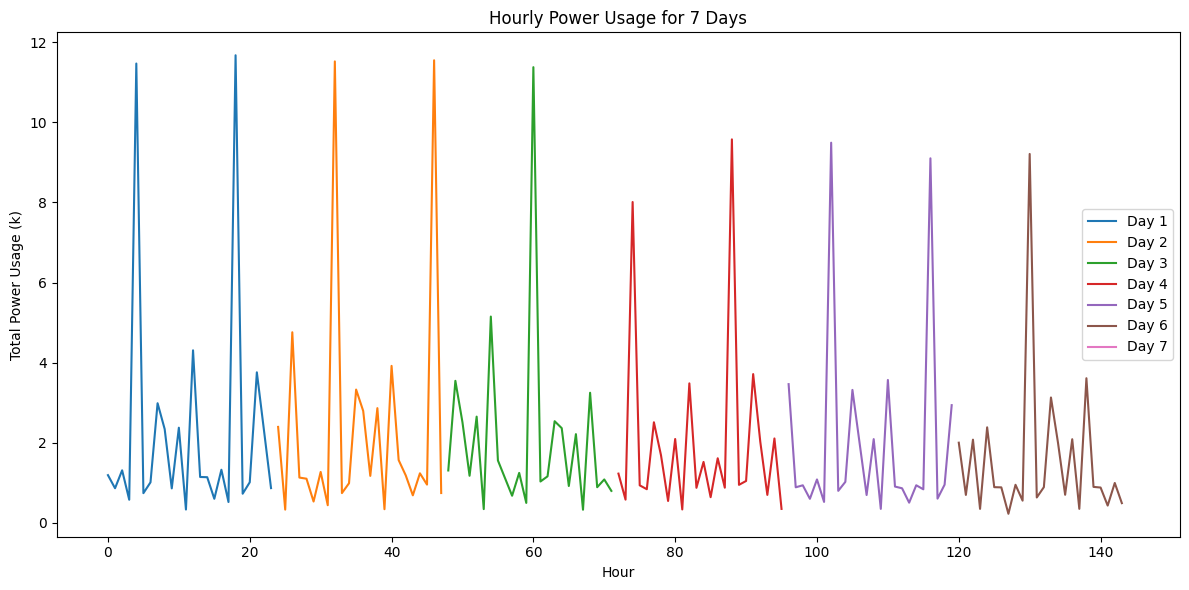

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hourly_power(hourly_power_data):
    """
    Plot hourly power usage data for 7 days with hours from 0 to 24 in an interval of 4 hours.

    Parameters:
        hourly_power_data (DataFrame): DataFrame containing hourly power usage data.

    Returns:
        None
    """
    # Create a figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot hourly power usage for each day
    for day in range(7):
        # Filter data for the current day
        data_day = hourly_power_data[day * 24: (day + 1) * 24]

        # Plot the data
        sns.lineplot(x=data_day.index, y='Total Power Usage (k)', data=data_day, label=f'Day {day+1}', ax=ax)

    # Set plot labels and title
    ax.set_xlabel('Hour')
    ax.set_ylabel('Total Power Usage (k)')
    ax.set_title('Hourly Power Usage for 7 Days')
    ax.legend()
    # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    # plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_hourly_power(new_df2)

In [ ]:
new_df2.columns=["Hours","Used_Power"]
new_df2

,Hours,Used_Power
0,2022-01-25 23:00,1.1920
1,2022-01-26 0:00,0.8652
2,2022-01-26 1:00,1.3125
3,2022-01-26 2:00,0.5785
4,2022-01-26 3:00,11.4675
...,...,...
140,2022-01-31 19:00,0.8828
141,2022-01-31 20:00,0.4325
142,2022-01-31 21:00,0.9967
143,2022-01-31 22:00,0.4932


In [ ]:
new_df2.set_index('Hours',inplace=True)

In [ ]:
new_df2.head()

,Used_Power
Hours,
2022-01-25 23:00,1.1920
2022-01-26 0:00,0.8652
2022-01-26 1:00,1.3125
2022-01-26 2:00,0.5785
2022-01-26 3:00,11.4675


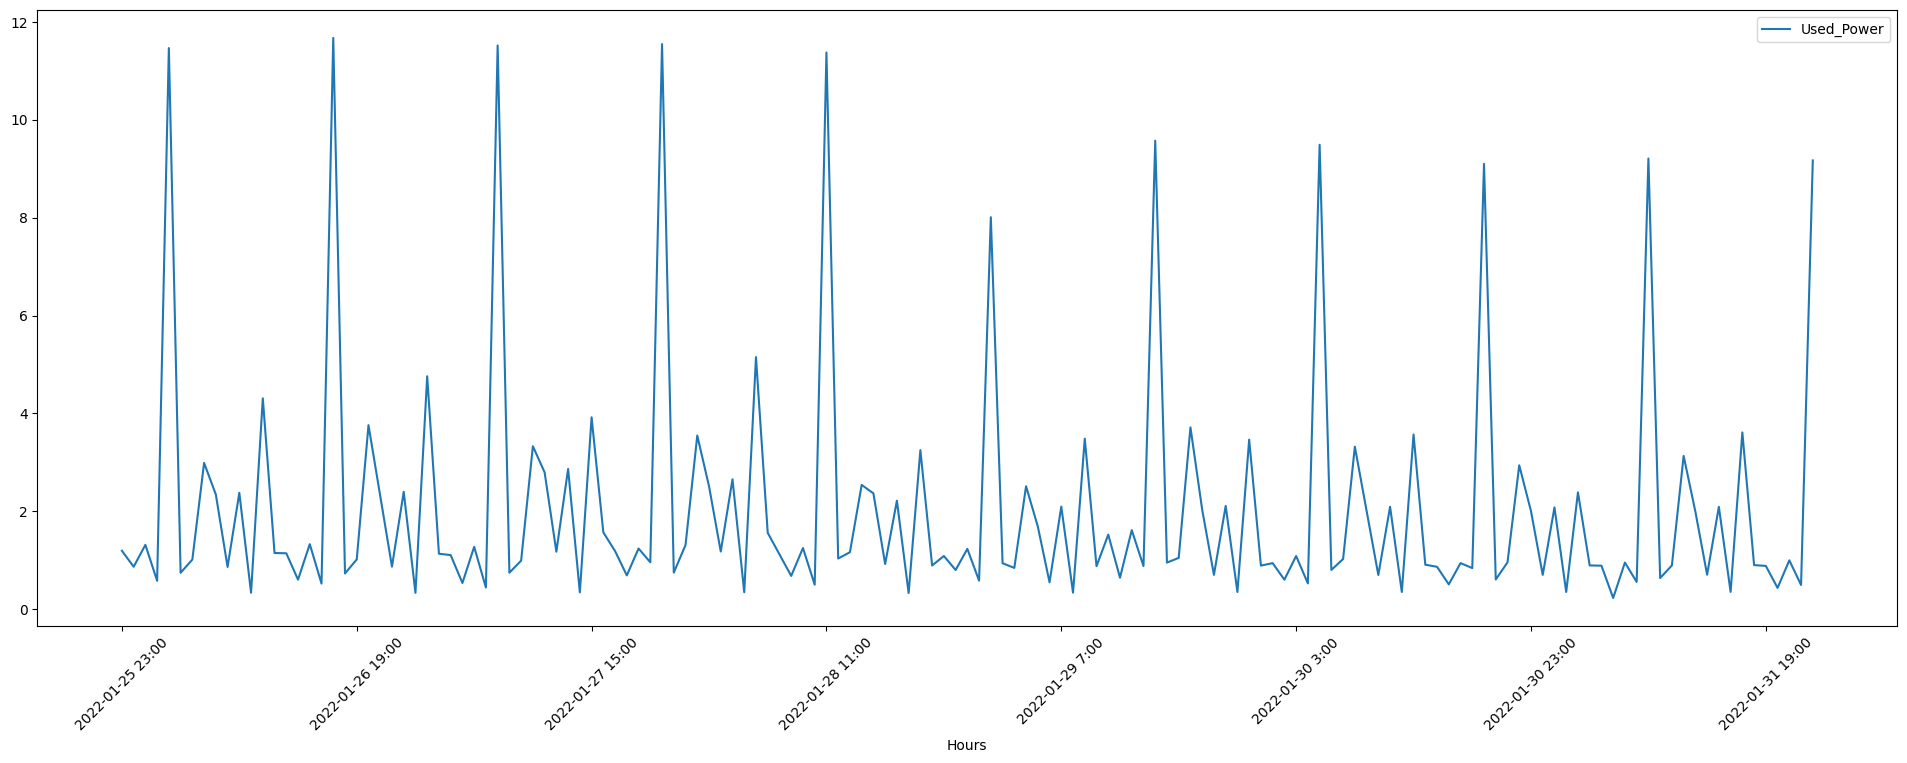

In [ ]:
def plot_dataframe(dataframe):
    """
    Plot a DataFrame with figsize=(12, 8) and rotate the horizontal axis labels by 45 degrees.

    Parameters:
        dataframe (DataFrame): The DataFrame to be plotted.
    """
    ax = dataframe.plot(figsize=(24, 8))
    plt.xticks(rotation=45)
    plt.show()

plot_dataframe(new_df2)

In [ ]:
#Testing for stationary by Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(new_df2['Used_Power'])

In [ ]:
#H0--> Null Hypothesis: It is non-stationary
#H1--> Alternate Hypothesis: It is stationary

def adfuller_test(sales):
  result=adfuller(sales)
  labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
  for value,label in zip(result,labels):
    print(label + ' : ' + str(value))
  if result[1]<=0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis, Data has no unity root")
  else:
    print("weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

In [ ]:
adfuller_test(new_df2['Used_Power'])

ADF Test Statistic : -0.7421446649610934
p-value : 0.8355291052963663
#Lags Used : 13
Number of Observations Used : 131
weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


# **Differencing**

In [ ]:
def apply_seasonal_difference(df, column, lag=24):
    """
    Apply seasonal differencing to a specified column in the DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        column (str): Name of the column to apply differencing to.
        lag (int): Lag value for seasonal differencing (default is 24 for daily data).

    Returns:
        df (DataFrame): DataFrame with seasonal differencing applied.
    """
    # Apply seasonal differencing
    df['Seasonal First Difference'] = df[column] - df[column].shift(lag)

    return df

new_df2 = apply_seasonal_difference(new_df2, 'Used_Power')


In [ ]:
new_df2.head()

,Used_Power,Seasonal First Difference
Hours,,
2022-01-25 23:00,1.1920,NaN
2022-01-26 0:00,0.8652,NaN
2022-01-26 1:00,1.3125,NaN
2022-01-26 2:00,0.5785,NaN
2022-01-26 3:00,11.4675,NaN


In [ ]:
#Now we'll apply the Dicky-Fuller test on the Seasonal First Difference column
adfuller_test(new_df2['Seasonal First Difference'].dropna())

ADF Test Statistic : -1.1230185488028892
p-value : 0.7058056330906314
#Lags Used : 13
Number of Observations Used : 107
weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


In [ ]:
#Again Differencing
#Since our data is not stationary, we'll apply differencing to make it stationary
#Again Shifting it by 48
new_df2['Seasonal First Difference'] = new_df2['Used_Power']-new_df2['Used_Power'].shift(48)

In [ ]:
#Now again we'll apply the Dicky-Fuller test on the Seasonal First Difference column
adfuller_test(new_df2['Seasonal First Difference'].dropna())

ADF Test Statistic : -8.86758673529363
p-value : 1.4265273119316466e-14
#Lags Used : 11
Number of Observations Used : 85
strong evidence against the null hypothesis(Ho), reject the null hypothesis, Data has no unity root


In [ ]:
#d=2 as we required two times differencing

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

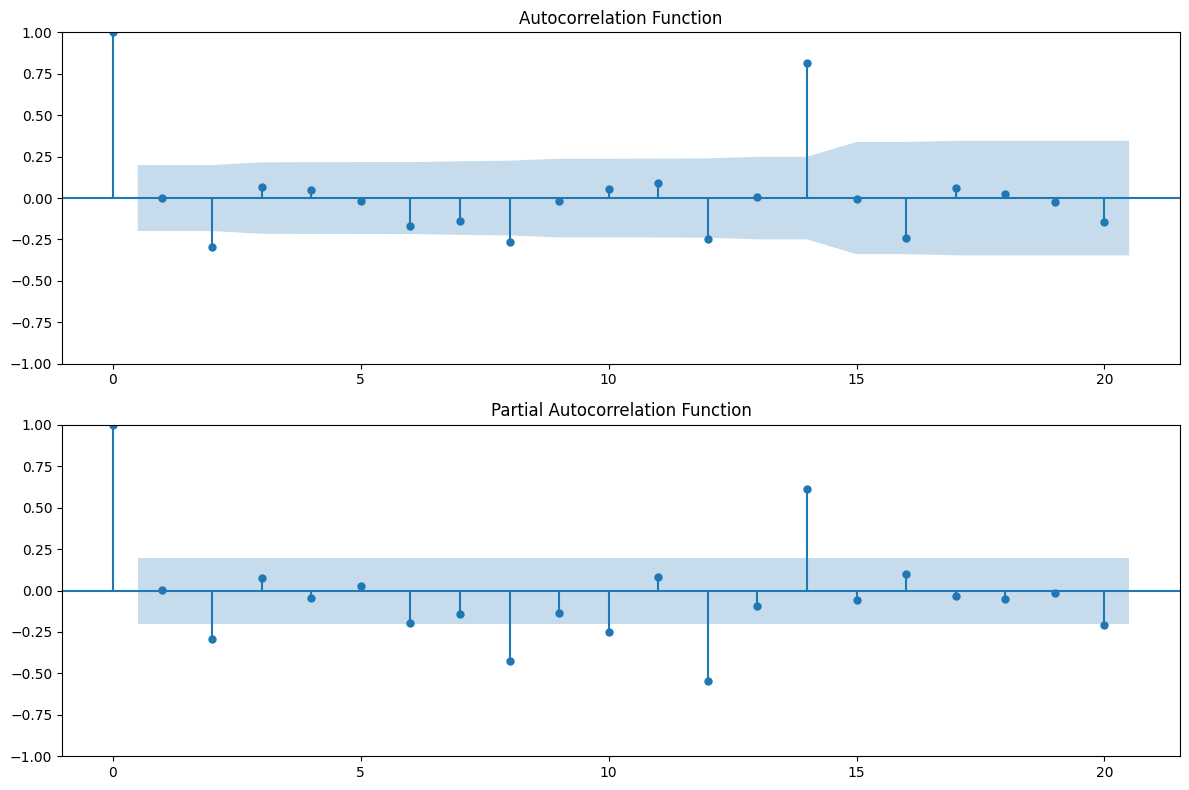

In [ ]:
def plot_acf_pacf(data, lag=48):
    """
    Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) for the data.

    Parameters:
        data (Series): Time series data.
        lag (int): Number of lags to include in the plots (default is 48).

    Returns:
        None
    """
    # Create a figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot ACF
    sm.graphics.tsa.plot_acf(data.iloc[lag:], ax=ax1)
    ax1.set_title('Autocorrelation Function')

    # Plot PACF
    sm.graphics.tsa.plot_pacf(data.iloc[lag:], ax=ax2)
    ax2.set_title('Partial Autocorrelation Function')

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_acf_pacf(new_df2['Seasonal First Difference'])

In [ ]:
# From the plot of PACF, p=1
# From the plot of ACF, q=0 or 1
# d=2

# **ARIMA Model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

def fit_arima_model(data, order=(1, 0, 2)):
    """
    Fit an ARIMA model to the given time series data.

    Parameters:
        data (Series): Time series data.
        order (tuple): Order of the ARIMA model (p, d, q).

    Returns:
        model_fit: Fitted ARIMA model.
    """
    # Fit ARIMA model
    model = ARIMA(data, order=order)
    model_fit = model.fit()

    return model_fit

# Example usage:
model_fit = fit_arima_model(new_df2['Used_Power'], order=(1, 0, 2))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Used_Power   No. Observations:                  145
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -331.944
Date:                Mon, 06 May 2024   AIC                            673.888
Time:                        17:12:56   BIC                            688.771
Sample:                    01-25-2022   HQIC                           679.935
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0971      0.145     14.417      0.000       1.812       2.382
ar.L1          0.4872      0.631      0.772      0.440      -0.749       1.724
ma.L1         -0.8352      0.678     -1.233      0.218      -2.163       0.493
ma.L2          0.0299      0.426      0.070      0.944      -0.805       0.865
sigma2         5.6883      0.747      7.616      0.000       4.224       7.152
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               162.28
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.83
Prob(H) (two-sided):                  0.19   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
new_df2['forecast']=model_fit.predict(start=120, end=144, dynamic =True)

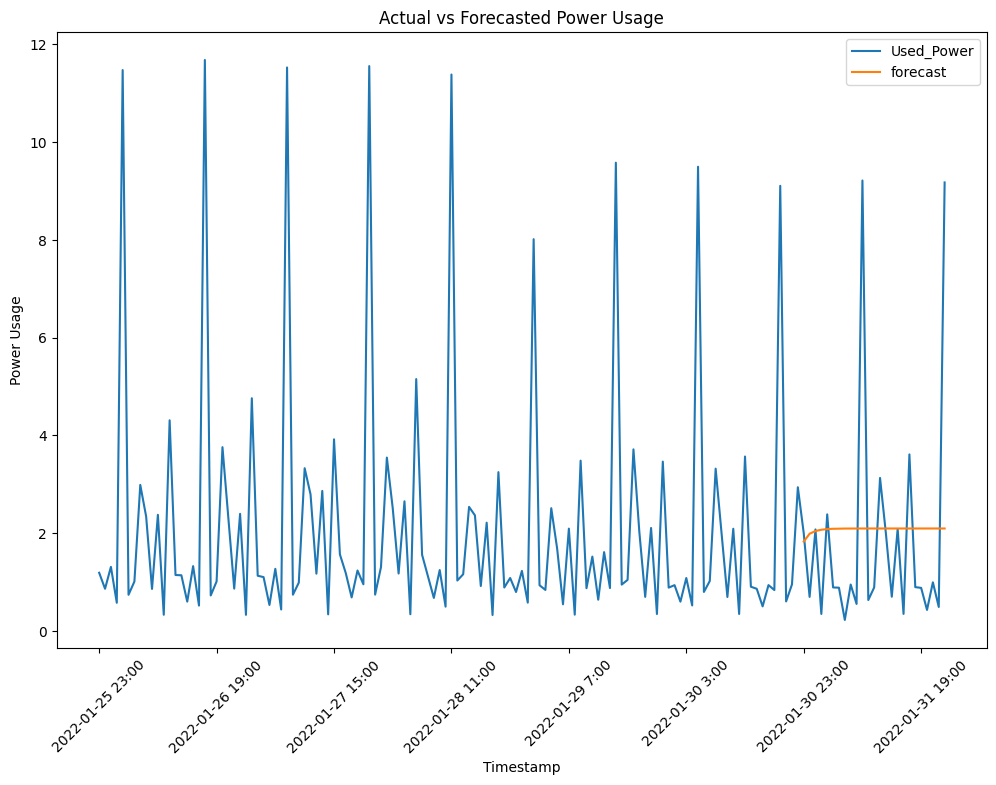

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_forecast(new_df2, start_index, end_index, dynamic=True):
    """
    Plot both the actual and forecasted power usage.

    Parameters:
        new_df2 (DataFrame): DataFrame containing power usage data and forecast.
        start_index (int): Start index for the forecast.
        end_index (int): End index for the forecast.
        dynamic (bool): Whether to use dynamic forecasting.

    Returns:
        None
    """
    # Generate forecast
    new_df2['forecast'] = model_fit.predict(start=start_index, end=end_index, dynamic=dynamic)

    # Plot actual vs forecasted power usage
    new_df2[['Used_Power', 'forecast']].plot(figsize=(12, 8))
    plt.xlabel('Timestamp')
    plt.ylabel('Power Usage')
    plt.title('Actual vs Forecasted Power Usage')
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.show()

# Example usage
plot_actual_vs_forecast(new_df2, start_index=120, end_index=144, dynamic=True)

# **SARIMA Model**

In [ ]:
#SARIMA MODEL
def fit_sarima_model(data, order=(1, 2, 1), seasonal_order=(2, 2, 3, 48)):
    """
    Fit a SARIMA model to the given time series data.

    Parameters:
        data (Series): Time series data.
        order (tuple): ARIMA order parameter (default is (1, 2, 1)).
        seasonal_order (tuple): Seasonal order parameter (default is (2, 2, 2, 24)).

    Returns:
        results (SARIMAXResultsWrapper): Fitted SARIMA model results.
    """
    # SARIMA MODEL
    model = sm.tsa.statespace.SARIMAX(data, order=order, seasonal_order=seasonal_order)

    # Fit the model
    results = model.fit()

    return results

# Example usage:
results = fit_sarima_model(new_df2['Used_Power'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Con

<Axes: xlabel='Hours'>

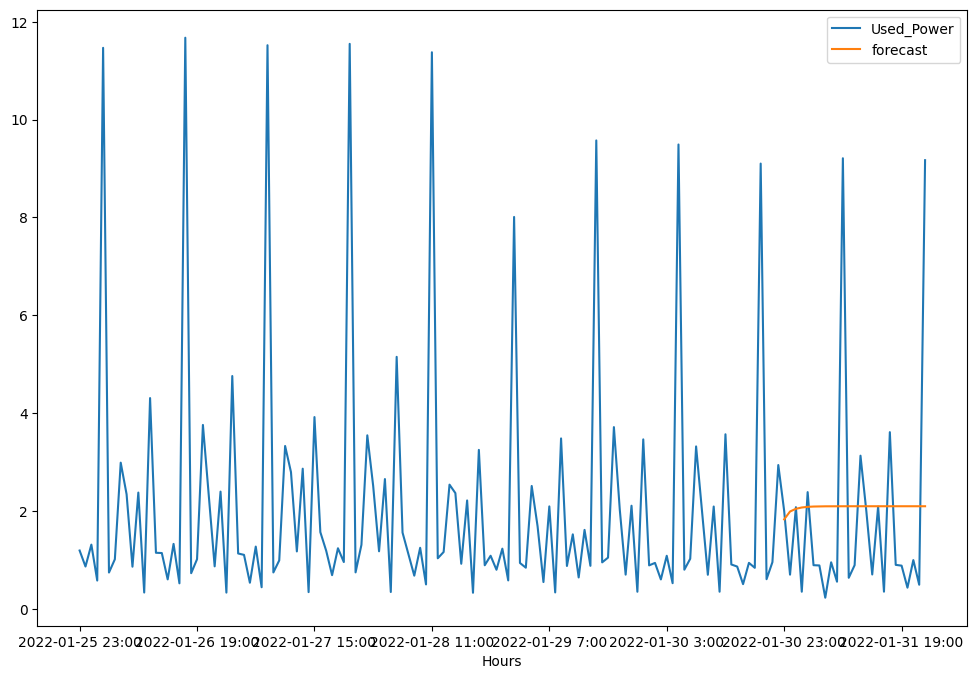

In [ ]:
new_df2[['Used_Power','forecast']].plot(figsize=(12,8))